# Filter questions answered - after fitting

See [questions.ipynb](./questions.ipynb) for the theory and questions.

See [answers.ipynb](./answers.ipynb) for initial answers.

## Experiment 1: r_series_tau

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/home/michael/dev/myokit/myokit/__init__.py:65: UserWarning: Using development version of Myokit (1.37.4.dev).
  warnings.warn(f'Using development version of Myokit ({__version__}).')


In [2]:
# Model with instantaneous summing, Fs, F1, and a 1-pole Rs comp lag
m = myokit.load_model('m-new-1.mmt')
m.check_units(myokit.UNIT_STRICT)

In [3]:
# Update model to parameters found by fitting
def update(m):
    m.get('amp.Rs').set_rhs('5.4238e-3 [GOhm]')
    m.get('amp.Cm').set_rhs('21.103 [pF]')
    m.get('amp.Cp').set_rhs('5.9253 [pF]')
    m.get('amp.g').set_rhs('2.0544 [nS]')
    m.get('amp.tau_amp').set_rhs('11.961e-6 [ms]')
    m.get('amp.Cf').set_rhs('3.7298e-3 [pF]')
    m.check_units(myokit.UNIT_STRICT)

update(m)

In [4]:
def configure(sim, log):
    """ Update the amplifier settings according to the given log. """
    def s(var, key, factor=1):
        sim.set_constant(f'amp.{var}', float(log.meta[key]) * factor)

    s('Cp_est', 'c_fast_pF')
    if log.meta['c_slow_compensation_enabled'] == 'true':
        s('Cm_est', 'c_slow_pF')
    else:
        sim.set_constant('amp.Cm_est', 1e-6)

    s('f1', 'filter1_kHz')
    s('Rs_est', 'r_series_MOhm', 1e-3)
    if log.meta['r_series_compensation_enabled'] == 'true':
        s('alpha', 'r_series_compensation_percent', 1e-2)
        s('tau_rc', 'r_series_compensation_tau_us', 1e-3)
    else:
        sim.set_constant('amp.alpha', 0)
        sim.set_constant('amp.tau_rc', 10e-3)
    sim.set_constant('amp.beta', 0)

def repeat(sim, log):
    sim.reset()
    configure(sim, log)
    return sim.run(200, log_interval=0.005)

In [5]:
p = myokit.Protocol()
p.add_step(level=-100, duration=100)
p.add_step(level=+100, duration=100)

Now let's compare with the data:

In [6]:
def load(exp, *selection):
    logs = []
    for s in selection:
        logs.append(myokit.DataLog.load(
            f'data/E-{exp}-{s:0>3}-FilterTest.zip').npview())
    return logs

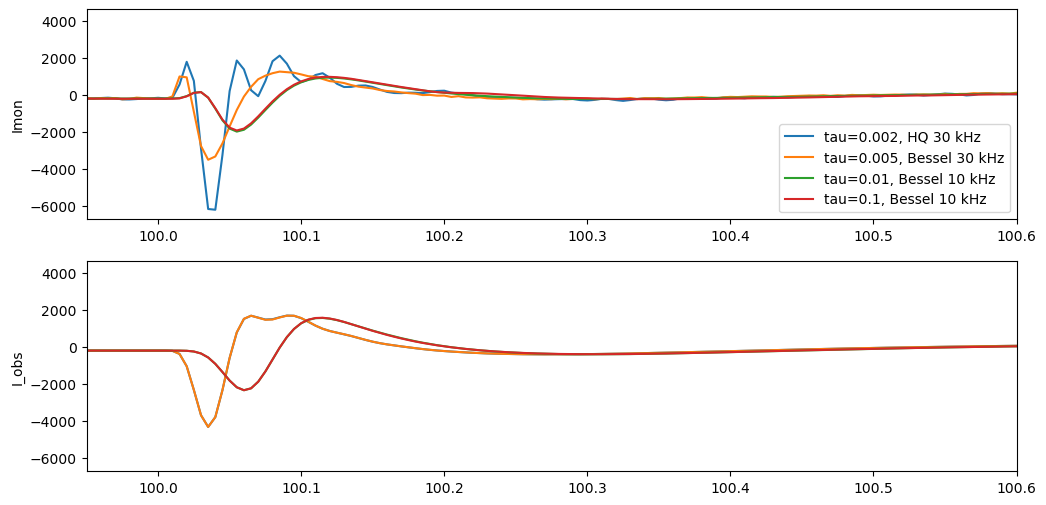

In [7]:
s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(408, 3, 2, 1, 0):
    tau = float(d.meta['r_series_compensation_tau_us']) * 1e-3
    f1 = d.meta['filter1']
    ax1.plot(d.time(), d['0.Imon'], label=f'tau={tau}, {f1}')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend()
plt.show()

## Experiment 2a: Stimulus filter


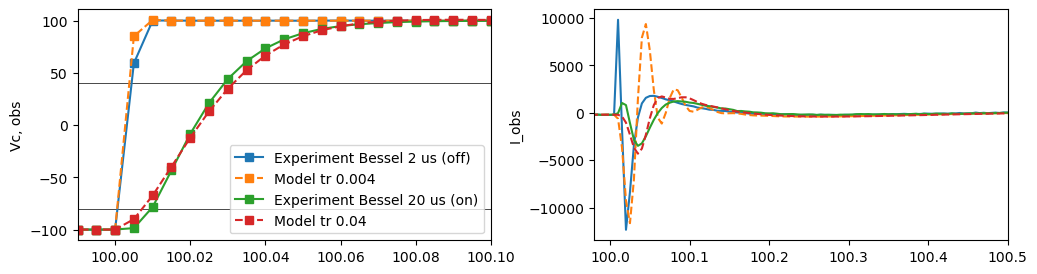

In [8]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.99, 100.1)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.98, 100.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for d, tr in zip(load(409, 3, 2), (0.004, 0.04)):
    ax1.plot(d.time(), d['0.Vmon'], 's-', label=f'Experiment {d.meta['stimulus_filter']}')
    ax2.plot(d.time(), d['0.Imon'])
    s.reset()
    configure(s, d)
    s.set_constant('amp.tr', tr)
    e = s.run(200, log_interval=0.005)
    ax1.plot(e.time(), e['amp.Vs2'], 's--', label=f'Model tr {tr}')
    ax2.plot(e.time(), e['amp.I_obs'], '--')
ax1.legend()
plt.show()

Note that this is a prediction.

## Experiment 2b: Filter1

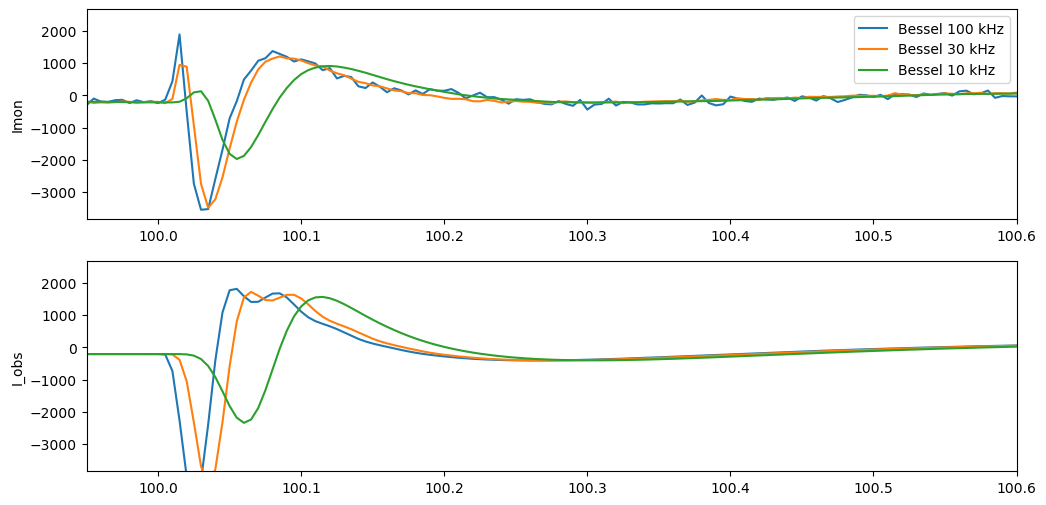

In [9]:
s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(410, 0, 1, 2):
    ax1.plot(d.time(), d['0.Imon'], label=d.meta['filter1'])
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend()
plt.show()

## Experiment 2c: Filter2

In [10]:
# Model with instantaneous summing, Fs, F1, F2, and a 1-pole Rs comp lag
mf2 = myokit.load_model('m-new-2.mmt')
update(mf2)
mf2.check_units(myokit.UNIT_STRICT)

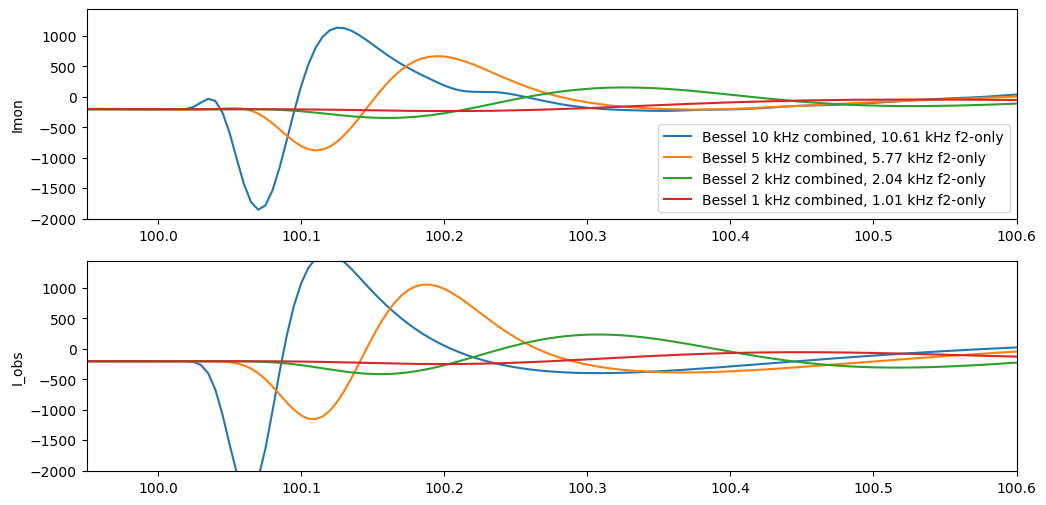

In [11]:
s = myokit.Simulation(mf2, p)
s.set_tolerance(1e-8, 1e-8)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(411, 1, 2, 3, 4):
    ax1.plot(d.time(), d['0.Imon'], label=d.meta['filter2'])
    s.reset()
    configure(s, d)
    s.set_constant('amp.f2', float(d.meta['filter2_kHz']))
    e = s.run(200, log_interval=0.005)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend()
plt.show()

## Experiment 2d: Cfast estimates

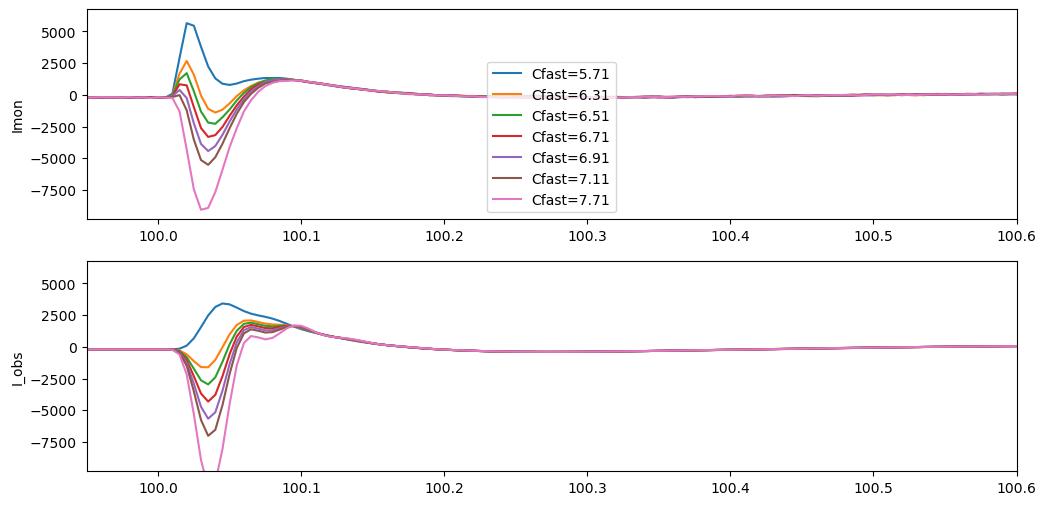

In [12]:
s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(412, 6, 2, 1, 5, 3, 4, 8):
    cf = float(d.meta['c_fast_pF'])
    ax1.plot(d.time(), d['0.Imon'], label=f'Cfast={cf:.3}')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend()
plt.show()

### Cell-attached Cfast variation

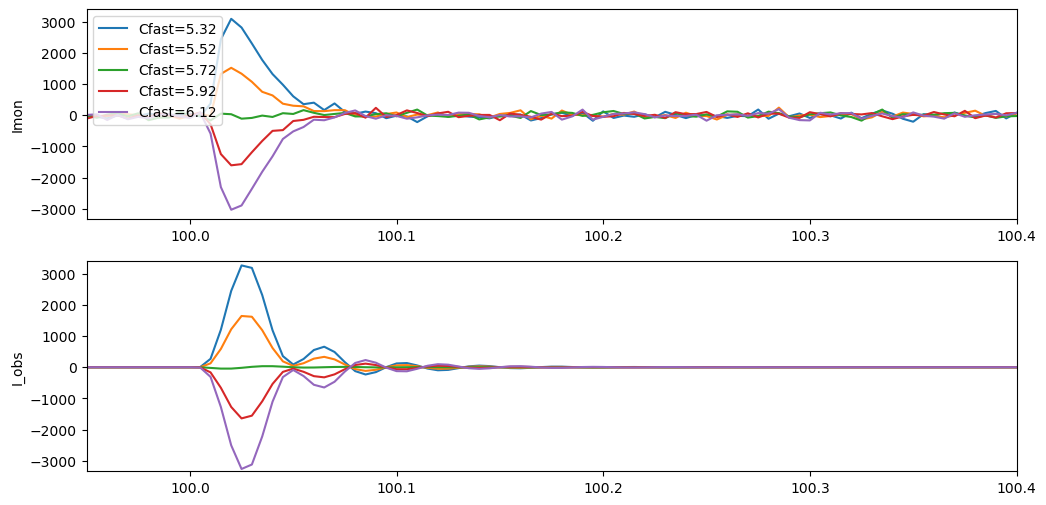

In [13]:
s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
xlim = 99.95, 100.4
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(417, 2, 1, 0, 3, 4):
    cf = float(d.meta['c_fast_pF'])
    ax1.plot(d.time(), d['0.Imon'], label=f'Cfast={cf:.3}')
    configure(s, d)
    s.reset()
    s.set_constant('amp.Cm', 1e-6)
    s.set_constant('amp.Cm_est', 1e-6)
    s.set_constant('amp.g', 0)
    s.set_constant('amp.Cp', 5.72)
    e = s.run(200, log_interval=0.005)    
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend()
plt.show()

**Note that this data wasn't used in fitting and so this is a prediction:** The true value of Cp in this case is unknown, and probably differs from what we used above.

## Experiment 2e: Cslow estimates

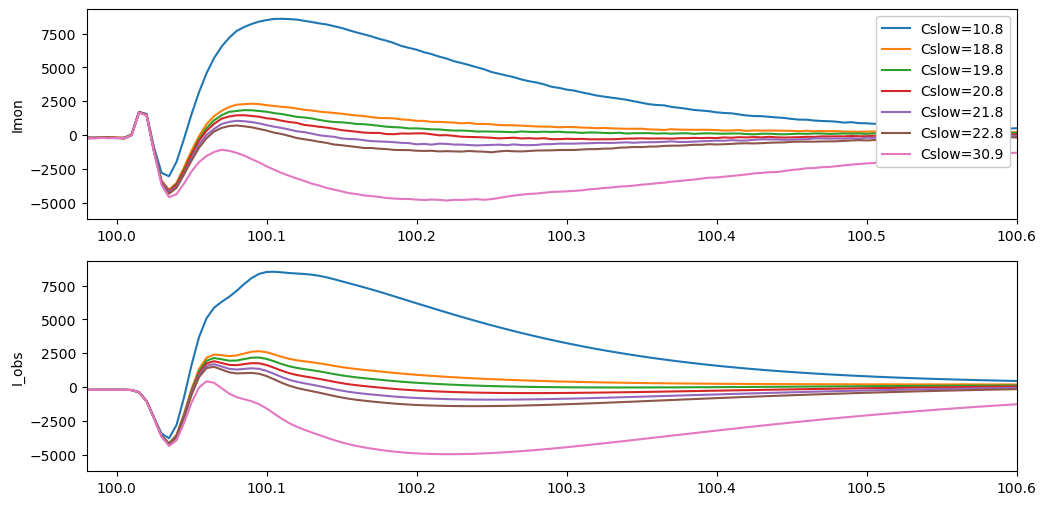

In [14]:
s = myokit.Simulation(m, p)
xlim = 99.98, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(413, 6, 2, 1, 0, 3, 4, 7):
    cs = float(d.meta['c_slow_pF'])
    ax1.plot(d.time(), d['0.Imon'], label=f'Cslow={cs:.3}')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper right', framealpha=1)
plt.show()

## Experiment 3a: `r_series_tau` again

Qualitatively we get this right, but for some reason with a much smaller amplitude.

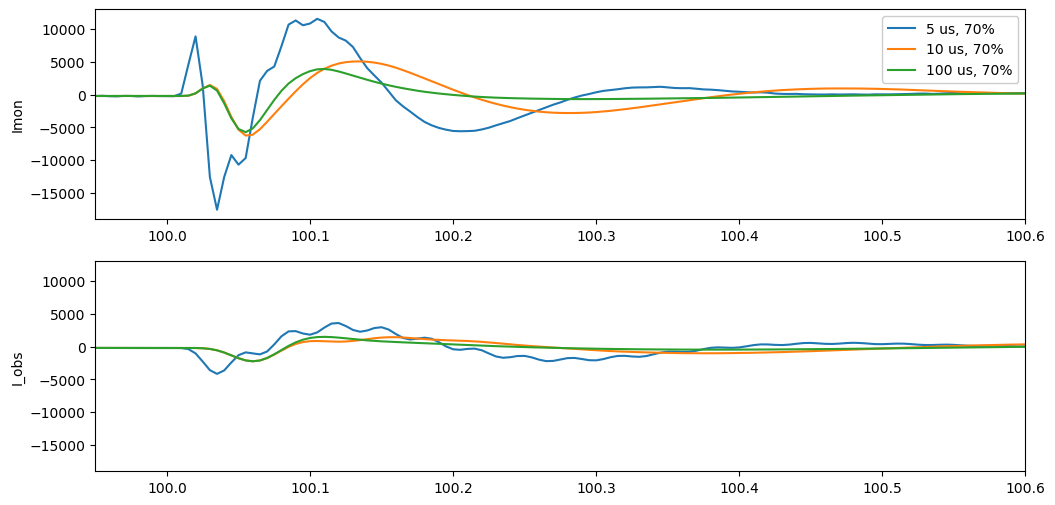

In [15]:
s = myokit.Simulation(m, p)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(414, 3, 1, 0):
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax1.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper right', framealpha=1)
plt.show()

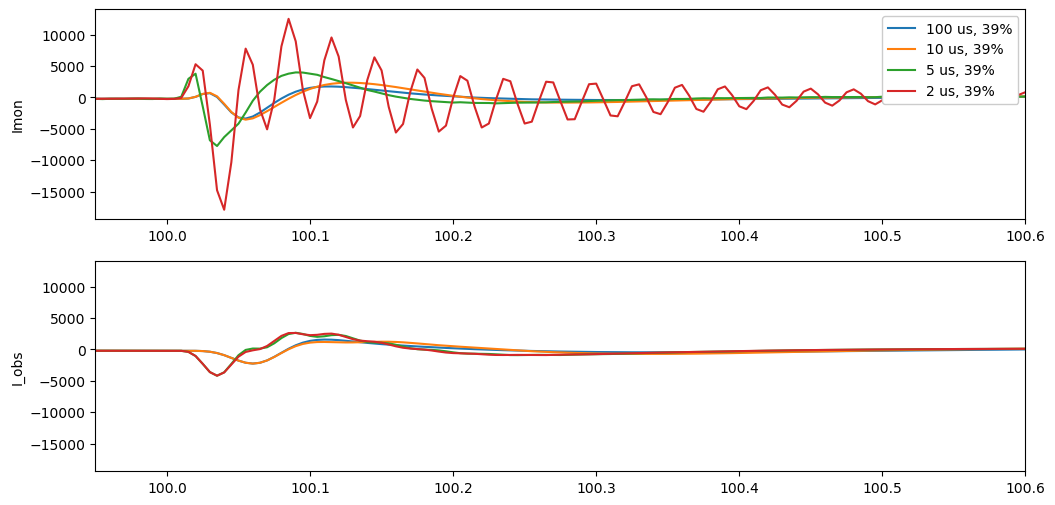

In [16]:
s = myokit.Simulation(m, p)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(414, 8, 7, 6, 5):
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax1.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper right', framealpha=1)
plt.show()

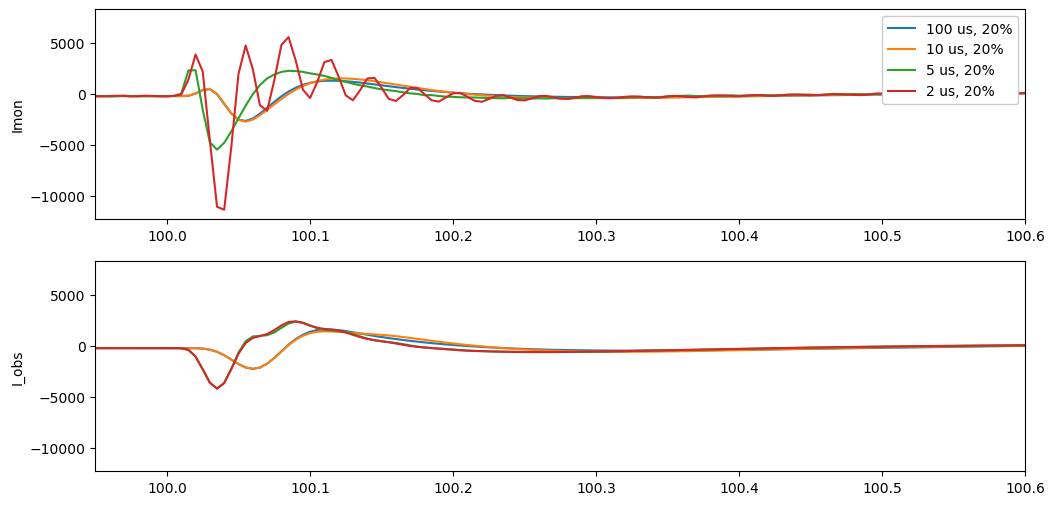

In [17]:
s = myokit.Simulation(m, p)
xlim = 99.95, 100.6
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlim(*xlim)
ax1.set_ylabel('Imon')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(*xlim)
ax2.set_ylabel('I_obs')
for d in load(414, 12, 11, 10, 9):
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax1.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
    e = repeat(s, d)
    ax2.plot(e.time(), e['amp.I_obs'])    
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper right', framealpha=1)
plt.show()

## Experiment 3b: `r_series_tau` with prediction

Didn't note down prediction fraction!